In [1]:
# For this version, we use a baseline hierarchical attention network as demonstrated by this notebook:
# https://www.kaggle.com/mlwhiz/learning-text-classification-attention
# Used as baseline for further enhancement

In [17]:
# Some imports, we are not gong to use all the imports in this workbook but in subsequent workbooks we surely will.
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define some Global Variables
max_features = 100000 # Maximum Number of words we want to include in our dictionary
maxlen = 72 # No of words in question we want to create a sequence with
embed_size = 300# Size of word to vec embedding we are using

In [3]:
# Some preprocesssing that will be common to all the text classification methods you will see. 
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

# Loading the data
def load_and_prec():
    train_df = pd.read_csv("../input/train.csv")
    test_df = pd.read_csv("../input/test.csv")
    
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=0.08, random_state=2018) # .08 since the datasize is large enough.

    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    '''
    keras.preprocessing.text.Tokenizer tokenizes(splits) the texts into tokens(words).
    Signature:
    Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True, split=' ', char_level=False, oov_token=None, document_count=0, **kwargs)

    The num_words parameter keeps a prespecified number of words in the text only. 
    It also filters some non wanted tokens by default and converts the text into lowercase.

    It keeps an index of words(dictionary of words which we can use to assign a unique number to a word) 
    which can be accessed by tokenizer.word_index.
    For example - For a text corpus the tokenizer word index might look like. 
    The words in the indexed dictionary are sort of ranked in order of frequencies,
    {'the': 1,'what': 2,'is': 3, 'a': 4, 'to': 5, 'in': 6, 'of': 7, 'i': 8, 'how': 9}
    
    The texts_to_sequence function converts every word(token) to its respective index in the word_index
    
    So Lets say we started with 
    train_X as something like ['This is a sentence','This is another bigger sentence']
    and after fitting our tokenizer we get the word_index as {'this':1,'is':2,'sentence':3,'a':4,'another':5,'bigger':6}
    The texts_to_sequence function will tokenize the sentences and replace words with individual tokens to give us 
    train_X = [[1,2,4,3],[1,2,5,6,3]]
    '''
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences. We need to pad the sequence with 0's to achieve consistent length across examples.
    '''
    We had train_X = [[1,2,4,3],[1,2,5,6,3]]
    lets say maxlen=6
        We will then get 
        train_X = [[1,2,4,3,0,0],[1,2,5,6,3,0]]
    '''
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values  
    
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index

In [4]:
%%time
train_X, val_X, test_X, train_y, val_y, word_index = load_and_prec()


Train shape :  (1306122, 3)
Test shape :  (56370, 2)
CPU times: user 1min 49s, sys: 864 ms, total: 1min 49s
Wall time: 1min 50s


In [5]:
# Word 2 vec Embedding

def load_glove(word_index):
    '''We want to create an embedding matrix in which we keep only the word2vec for words which are in our word_index
    '''
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [6]:
embedding_matrix = load_glove(word_index)

In [7]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [8]:
def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
model = model_lstm_atten(embedding_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 72, 300)           30000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72, 256)           440320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 72, 128)           164864    
_________________________________________________________________
attention_with_context_1 (At (None, 128)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total para

In [18]:
def focal_loss(gamma=2, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):#with tensorflow
        eps = 1e-12
        y_pred=K.clip(y_pred,eps,1.-eps)#improve the stability of the focal loss and see issues 1 for more information
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def train_pred(model, epochs=2):
    filepath="weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    history = model.fit(train_X, train_y, batch_size=512, epochs=epochs, validation_data=(val_X, val_y),callbacks=callbacks)
    model.load_weights(filepath)
    pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_val_y, pred_test_y, history


In [19]:
%%time
pred_val_y, pred_test_y, history = train_pred(model, epochs=15)

Train on 1201632 samples, validate on 104490 samples
Epoch 1/15
1201632/1201632 [==============================] - 263s 219us/step - loss: 0.0759 - acc: 0.9690 - val_loss: 0.0992 - val_acc: 0.9610

Epoch 00001: val_loss improved from inf to 0.09925, saving model to weights_best.h5
Epoch 2/15
1201632/1201632 [==============================] - 263s 219us/step - loss: 0.0731 - acc: 0.9702 - val_loss: 0.1001 - val_acc: 0.9610

Epoch 00002: val_loss did not improve from 0.09925
Epoch 3/15
1201632/1201632 [==============================] - 263s 219us/step - loss: 0.0708 - acc: 0.9712 - val_loss: 0.1021 - val_acc: 0.9605

Epoch 00003: val_loss did not improve from 0.09925
Epoch 4/15
1201632/1201632 [==============================] - 263s 219us/step - loss: 0.0686 - acc: 0.9721 - val_loss: 0.1033 - val_acc: 0.9601

Epoch 00004: val_loss did not improve from 0.09925
Epoch 5/15
1201632/1201632 [==============================] - 263s 219us/step - loss: 0.0663 - acc: 0.9730 - val_loss: 0.1053 - va

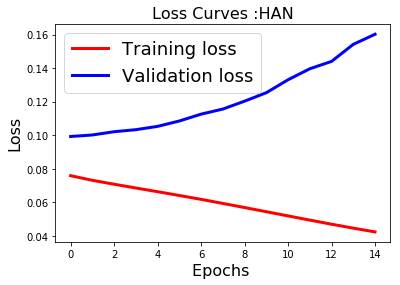

In [20]:
fig1 = plt.figure()
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves :HAN', fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

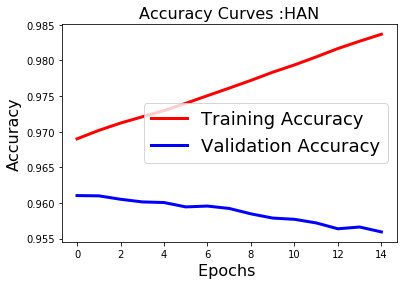

In [21]:
fig1 = plt.figure()
plt.plot(history.history['acc'], 'r', linewidth=3.0)
plt.plot(history.history['val_acc'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves :HAN', fontsize=16)
fig1.savefig('acc_han.png')
plt.show()

In [22]:
'''
A function specific to this competition since the organizers don't want probabilities 
and only want 0/1 classification maximizing the F1 score. This function computes the best F1 score by looking at val set predictions
'''

def f1_smart(y_true, y_pred):
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = metrics.f1_score(y_true, (y_pred > thresh).astype(int))
        thresholds.append([thresh, res])
        print("F1 score at threshold {0} is {1}".format(thresh, res))

    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    best_f1 = thresholds[0][1]
    print("Best threshold: ", best_thresh)
    return  best_f1, best_thresh

In [23]:
f1, threshold = f1_smart(val_y, pred_val_y)
print('Optimal F1: {} at threshold: {}'.format(f1, threshold))

F1 score at threshold 0.1 is 0.6390102718347427
F1 score at threshold 0.11 is 0.646583564173592
F1 score at threshold 0.12 is 0.6508494434680727
F1 score at threshold 0.13 is 0.6558117423342049
F1 score at threshold 0.14 is 0.659609022556391
F1 score at threshold 0.15 is 0.6628126331162905
F1 score at threshold 0.16 is 0.666913123844732
F1 score at threshold 0.17 is 0.6703645995637271
F1 score at threshold 0.18 is 0.6730963187090268
F1 score at threshold 0.19 is 0.6765136563315718
F1 score at threshold 0.2 is 0.6784842646114323
F1 score at threshold 0.21 is 0.6802694649566006
F1 score at threshold 0.22 is 0.6816993464052288
F1 score at threshold 0.23 is 0.6833508956796628
F1 score at threshold 0.24 is 0.6838435487084136
F1 score at threshold 0.25 is 0.685519454472523
F1 score at threshold 0.26 is 0.6850053937432579
F1 score at threshold 0.27 is 0.6848217317487267
F1 score at threshold 0.28 is 0.6860814875581076
F1 score at threshold 0.29 is 0.6860016533480298
F1 score at threshold 0.3 

In [15]:
pred_test_y = (pred_test_y >threshold).astype(int)
test_df = pd.read_csv("../input/test.csv", usecols=["qid"])
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)

References

Based on mlwhiz's kernel: https://www.kaggle.com/mlwhiz/learning-text-classification-attention